In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import camb
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import camb.correlations
from camb import model, initialpower
import numpy as np
import astropy.table
import pandas as pd
import pickle
from astroML.datasets import fetch_sdss_specgals

In [36]:
import math

In [4]:
data = fetch_sdss_specgals()
m_max = 17.7
# redshift and magnitude cuts
data = data[data['z'] > 0.08]
data = data[data['z'] < 0.12]
data = data[data['petroMag_r'] < m_max]
# RA/DEC cuts
RAmin, RAmax = 140, 220 
DECmin, DECmax = 5, 45
data = data[data['ra'] < RAmax] 
data = data[data['ra'] > RAmin] 
data = data[data['dec'] < DECmax] 
data = data[data['dec'] > DECmin]
ur = data['modelMag_u'] - data['modelMag_r'] 
flag_red = (ur > 2.22)
flag_blue = ~flag_red
data_red = data[flag_red] 
data_blue = data[flag_blue]
print("data size:")
print(" red gals: ", len(data_red)) 
print(" blue gals:", len(data_blue))

data size:
 red gals:  38017
 blue gals: 16883


In [5]:
cut1 = pd.cut(data['z'], bins = 25)
Nz = cut1.value_counts().tolist()

keys1 = cut1.value_counts().keys()

z = []
for i in range(len(keys1)):
    z.append(keys1[i].mid)

In [6]:
#plt.hist(data['z'], bins = 100)

Nz, be = np.histogram(data['z'][flag_red], bins=8, range=(0.05,0.15))

In [7]:
def getcorr(lmax):
    pars = camb.CAMBparams() # Set up the CAMB parameters
    h=0.675 # Planck value for h (Hubble parameter)
    Ob = 0.044 # Planck value for Omega_b (Baryon energy density)
    Om = 0.31 # Planck value for Omega_m (Matter energy density)
    Oc = Om-Ob # Value for Omega_c (Cold dark matter energy density)
    As=2e-9 # Amplitude of initial fluctuations
    ns=0.965 # Scalar index
    pars.set_cosmology(H0=100*h, ombh2=Ob*h**2, omch2=Oc*h**2) # This sets the cosmological parameters
    pars.InitPower.set_params(As=As, ns=ns) # This also sets the cosmological parameters
    pars.set_for_lmax(lmax, lens_potential_accuracy=1) # Set the maximum ell
    #set Want_CMB to true if you also want CMB spectra or correlations
    pars.Want_CMB = False # We don't want the CMB
    #NonLinear_both or NonLinear_lens will use non-linear corrections
    pars.NonLinear = model.NonLinear_both # We want non-linear corrections
    #Set up W(z) window functions, later labelled W1, W2.
    zs = 0.5*(be[1:] + be[:-1]) #z # Range of zs
    W = Nz # Window function
    pars.SourceWindows = [SplinedSourceWindow(source_type='counts', bias=1.0, z=zs, W=W)] # Set up the window function
    
    results = camb.get_results(pars)
    cls = results.get_source_cls_dict()
    ls=  np.arange(2, lmax+1)
    
    angles = np.logspace(-2, 1) # Angles from 0.01 to 10 deg
    x = np.cos(np.radians(angles)) # Convert them to radians and compute cosine to passs to CAMB
    cls_in = np.array([cls['W1xW1'][1:lmax+1], np.zeros(lmax), np.zeros(lmax), np.zeros(lmax)]).T
    #cl2corr needs TT (temperature/density), EE (E-mode), BB (B-mode), TE (Temperature-polarization cross correlation) -> we only care about TT
    w_camb = camb.correlations.cl2corr(cls_in, x);
    
    return w_camb

In [8]:
w_30000 = getcorr(30000)[:,0]

In [9]:
w_15000 = getcorr(15000)[:,0]

In [10]:
w_7500 = getcorr(7500)[:,0]

In [11]:
w_3750 = getcorr(3750)[:,0]

In [12]:
w_1875 = getcorr(1875)[:,0]

In [13]:
diff_15000 = 1 - w_15000/w_30000
diff_7500 = 1 - w_7500/w_30000
diff_3750 = 1 - w_3750/w_30000
diff_1875 = 1 - w_1875/w_30000

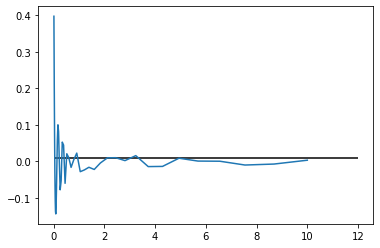

In [14]:
angles = np.logspace(-2, 1)
plt.plot(angles, diff_1875)
#plt.plot(angles, diff_3750)
#plt.plot(angles, diff_7500)
#plt.plot(angles, diff_15000)
plt.hlines(0.01,0,12)

In [51]:
[diff_15000[-1], diff_7500[-1], diff_3750[-1], diff_1875[-1]]

[0.00016515505226288862,
 -0.001087372721483959,
 -0.000949801591771493,
 0.003004812292656367]

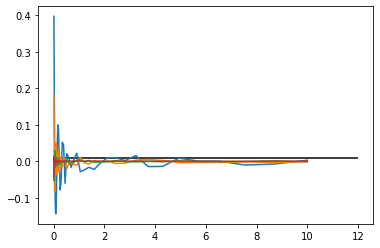

In [29]:
angles = np.logspace(-2, 1)
plt.plot(angles, diff_1875)
plt.plot(angles, diff_3750)
plt.plot(angles, diff_7500)
plt.plot(angles, diff_15000)
plt.hlines(0.01,0,12)

In [31]:
angles

array([ 0.01      ,  0.01151395,  0.01325711,  0.01526418,  0.01757511,
        0.0202359 ,  0.02329952,  0.02682696,  0.03088844,  0.0355648 ,
        0.04094915,  0.04714866,  0.05428675,  0.06250552,  0.07196857,
        0.08286428,  0.09540955,  0.10985411,  0.12648552,  0.14563485,
        0.16768329,  0.19306977,  0.22229965,  0.25595479,  0.29470517,
        0.33932218,  0.39069399,  0.44984327,  0.51794747,  0.59636233,
        0.68664885,  0.79060432,  0.91029818,  1.04811313,  1.20679264,
        1.38949549,  1.59985872,  1.84206997,  2.12095089,  2.44205309,
        2.8117687 ,  3.23745754,  3.72759372,  4.29193426,  4.94171336,
        5.68986603,  6.55128557,  7.54312006,  8.68511374, 10.        ])

In [39]:
math.e**angles

array([1.01005017e+00, 1.01158049e+00, 1.01334538e+00, 1.01538127e+00,
       1.01773046e+00, 1.02044203e+00, 1.02357307e+00, 1.02719004e+00,
       1.03137043e+00, 1.03620480e+00, 1.04179913e+00, 1.04827784e+00,
       1.05578731e+00, 1.06450033e+00, 1.07462157e+00, 1.08639435e+00,
       1.10010931e+00, 1.11611523e+00, 1.13483302e+00, 1.15677371e+00,
       1.18256203e+00, 1.21296742e+00, 1.24894557e+00, 1.29169433e+00,
       1.34273042e+00, 1.40399561e+00, 1.47800617e+00, 1.56806640e+00,
       1.67857877e+00, 1.81550258e+00, 1.98704547e+00, 2.20472839e+00,
       2.48506341e+00, 2.85226420e+00, 3.34274605e+00, 4.01282505e+00,
       4.95233271e+00, 6.30958540e+00, 8.33906323e+00, 1.14966202e+01,
       1.66393221e+01, 2.54688858e+01, 4.15789371e+01, 7.31077412e+01,
       1.40009932e+02, 2.95853982e+02, 7.00143678e+02, 1.88771062e+03,
       5.91421313e+03, 2.20264658e+04])

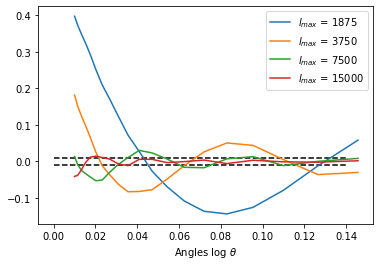

In [47]:
plt.plot(angles[:20], diff_1875[:20])
plt.plot(angles[:20], diff_3750[:20])
plt.plot(angles[:20], diff_7500[:20])
plt.plot(angles[:20], diff_15000[:20])
plt.hlines(0.01,0,0.14,linestyles='dashed')
plt.hlines(-0.01,0,0.14,linestyles='dashed')
plt.xlabel(r"Angles log $\theta$")
plt.legend([r'$l_{max}$ = 1875',r'$l_{max}$ = 3750',r'$l_{max}$ = 7500',r'$l_{max}$ = 15000'])

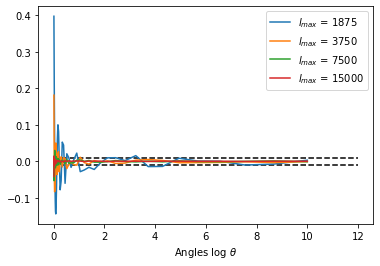

In [34]:
plt.plot(angles, diff_1875)
plt.plot(angles, diff_3750)
plt.plot(angles, diff_7500)
plt.plot(angles, diff_15000)
plt.hlines(0.01,0,12,linestyles='dashed')
plt.hlines(-0.01,0,12,linestyles='dashed')
plt.xlabel(r"Angles log $\theta$")
plt.legend([r'$l_{max}$ = 1875',r'$l_{max}$ = 3750',r'$l_{max}$ = 7500',r'$l_{max}$ = 15000'])